# Acceleration with Numba

We explore how the computation of cost functions can be dramatically accelerated with numba's JIT compiler.

The run-time of iminuit is usually dominated by the execution time of the cost function. To get good performance, it recommended to use array arthimetic and scipy and numpy functions in the body of the cost function. Python loops should be avoided, but if they are unavoidable, [Numba](https://numba.pydata.org/) can help. Numba can also parallelize numerical calculations to make full use of multi-core CPUs and even do computations on the GPU.

Note: This tutorial shows how one can generate faster pdfs with Numba. Before you start to write your own pdf, please check whether one is already implemented in the [numba_stats library](https://github.com/HDembinski/numba-stats). If you have a pdf that is not included there, please consider contributing it to numba_stats.

In [51]:
# !pip install matplotlib numpy numba scipy iminuit
from iminuit import Minuit
import numpy as np
import numba as nb
import math
from scipy.stats import expon, norm
from matplotlib import pyplot as plt
from argparse import Namespace

The standard fit in particle physics is the fit of a peak over some smooth background. We generate a Gaussian peak over exponential background, using scipy.

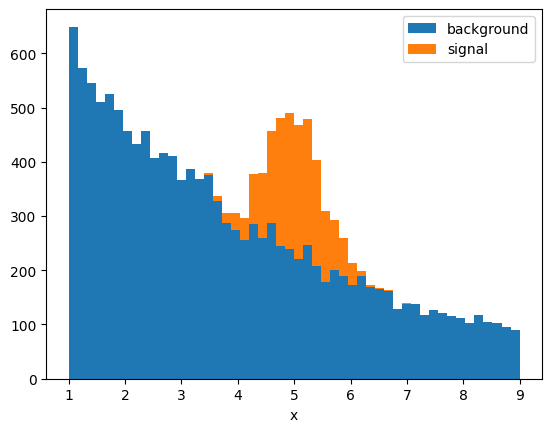

In [52]:
np.random.seed(1)  # fix seed

# true parameters for signal and background
truth = Namespace(n_sig=2000, f_bkg=10, sig=(5.0, 0.5), bkg=(0.0, 4.0))
n_bkg = truth.n_sig * truth.f_bkg

# make a data set
x = np.empty(truth.n_sig + n_bkg)

# fill m variables
x[: truth.n_sig] = norm(*truth.sig).rvs(truth.n_sig)
x[truth.n_sig :] = expon(*truth.bkg).rvs(n_bkg)

# cut a range in x
xrange = np.array((1.0, 9.0))
ma = (xrange[0] < x) & (x < xrange[1])
x = x[ma]

plt.hist(
    (x[truth.n_sig :], x[: truth.n_sig]),
    bins=50,
    stacked=True,
    label=("background", "signal"),
)
plt.xlabel("x")
plt.legend();

In [53]:
# ideal starting values for iminuit
start = np.array((truth.n_sig, n_bkg, truth.sig[0], truth.sig[1], truth.bkg[1]))


# iminuit instance factory, will be called a lot in the benchmarks blow
def m_init(fcn):
    m = Minuit(fcn, start, name=("ns", "nb", "mu", "sigma", "lambd"))
    m.limits = ((0, None), (0, None), None, (0, None), (0, None))
    m.errordef = Minuit.LIKELIHOOD
    return m

In [54]:
# extended likelihood (https://doi.org/10.1016/0168-9002(90)91334-8)
# this version uses numpy and scipy and array arithmetic
def nll(par):
    n_sig, n_bkg, mu, sigma, lambd = par
    s = norm(mu, sigma)
    b = expon(0, lambd)
    # normalisation factors are needed for pdfs, since x range is restricted
    sn = s.cdf(xrange)
    bn = b.cdf(xrange)
    sn = sn[1] - sn[0]
    bn = bn[1] - bn[0]
    return (n_sig + n_bkg) - np.sum(
        np.log(s.pdf(x) / sn * n_sig + b.pdf(x) / bn * n_bkg)
    )


nll(start)

-103168.78482586428

In [55]:
%%timeit -r 3 -n 1
m = m_init(nll)  # setup time is negligible
m.migrad();

132 ms ± 2.15 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


Let's see whether we can beat that. The code above is already pretty fast, because numpy and scipy routines are fast, and we spend most of the time in those. But these implementations do not parallelize the execution and are not optimised for this particular CPU, unlike numba-jitted functions.

To use numba, in theory we just need to put the `njit` decorator on top of the function, but often that doesn't work out of the box. numba understands many numpy functions, but no scipy. We must evaluate the code that uses scipy in 'object mode', which is numba-speak for calling into the Python interpreter.

In [56]:
# first attempt to use numba
@nb.njit(parallel=True)
def nll(par):
    n_sig, n_bkg, mu, sigma, lambd = par
    with nb.objmode(spdf="float64[:]", bpdf="float64[:]", sn="float64", bn="float64"):
        s = norm(mu, sigma)
        b = expon(0, lambd)
        # normalisation factors are needed for pdfs, since x range is restricted
        sn = np.diff(s.cdf(xrange))[0]
        bn = np.diff(b.cdf(xrange))[0]
        spdf = s.pdf(x)
        bpdf = b.pdf(x)
    no = n_sig + n_bkg
    return no - np.sum(np.log(spdf / sn * n_sig + bpdf / bn * n_bkg))


nll(start)  # test and warm-up JIT

-103168.78482586429

In [57]:
%%timeit -r 3 -n 1 m = m_init(nll)
m.migrad()

157 ms ± 3.75 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


It is even a bit slower. :( Let's break the original function down by parts to see why.

In [58]:
# let's time the body of the function
n_sig, n_bkg, mu, sigma, lambd = start
s = norm(mu, sigma)
b = expon(0, lambd)
# normalisation factors are needed for pdfs, since x range is restricted
sn = np.diff(s.cdf(xrange))[0]
bn = np.diff(b.cdf(xrange))[0]
spdf = s.pdf(x)
bpdf = b.pdf(x)

%timeit -r 3 -n 100 norm(*start[2:4]).pdf(x)
%timeit -r 3 -n 500 expon(0, start[4]).pdf(x)
%timeit -r 3 -n 1000 n_sig + n_bkg - np.sum(np.log(spdf / sn * n_sig + bpdf / bn * n_bkg))

475 µs ± 3.24 µs per loop (mean ± std. dev. of 3 runs, 100 loops each)
451 µs ± 5.18 µs per loop (mean ± std. dev. of 3 runs, 500 loops each)
66.3 µs ± 219 ns per loop (mean ± std. dev. of 3 runs, 1,000 loops each)


Most of the time is spend in `norm` and `expon` which numba could not accelerate and the total time is dominated by the slowest part.

This, unfortunately, means we have to do much more manual work to make the function faster, since we have to replace the scipy routines with Python code that numba can accelerate and run in parallel.

In [59]:
# when parallel is enabled, also enable associative math
kwd = {"parallel": True, "fastmath": {"reassoc", "contract", "arcp"}}


@nb.njit(**kwd)
def sum_log(fs, spdf, fb, bpdf):
    return np.sum(np.log(fs * spdf + fb * bpdf))


@nb.njit(**kwd)
def norm_pdf(x, mu, sigma):
    invs = 1.0 / sigma
    z = (x - mu) * invs
    invnorm = 1 / np.sqrt(2 * np.pi) * invs
    return np.exp(-0.5 * z ** 2) * invnorm


@nb.njit(**kwd)
def nb_erf(x):
    y = np.empty_like(x)
    for i in nb.prange(len(x)):
        y[i] = math.erf(x[i])
    return y


@nb.njit(**kwd)
def norm_cdf(x, mu, sigma):
    invs = 1.0 / (sigma * np.sqrt(2))
    z = (x - mu) * invs
    return 0.5 * (1 + nb_erf(z))


@nb.njit(**kwd)
def expon_pdf(x, lambd):
    inv_lambd = 1.0 / lambd
    return inv_lambd * np.exp(-inv_lambd * x)


@nb.njit(**kwd)
def expon_cdf(x, lambd):
    inv_lambd = 1.0 / lambd
    return 1.0 - np.exp(-inv_lambd * x)


def nll(par):
    n_sig, n_bkg, mu, sigma, lambd = par
    # normalisation factors are needed for pdfs, since x range is restricted
    sn = norm_cdf(xrange, mu, sigma)
    bn = expon_cdf(xrange, lambd)
    sn = sn[1] - sn[0]
    bn = bn[1] - bn[0]
    spdf = norm_pdf(x, mu, sigma)
    bpdf = expon_pdf(x, lambd)
    no = n_sig + n_bkg
    return no - sum_log(n_sig / sn, spdf, n_bkg / bn, bpdf)


nll(start)  # test and warm-up JIT

-103168.78482586429

Let's see how well these versions do:

In [60]:
%timeit -r 5 -n 100 norm_pdf(x, *start[2:4])
%timeit -r 5 -n 500 expon_pdf(x, start[4])
%timeit -r 5 -n 1000 sum_log(n_sig / sn, spdf, n_bkg / bn, bpdf)

111 µs ± 18.5 µs per loop (mean ± std. dev. of 5 runs, 100 loops each)
56.9 µs ± 1.02 µs per loop (mean ± std. dev. of 5 runs, 500 loops each)
59.1 µs ± 929 ns per loop (mean ± std. dev. of 5 runs, 1,000 loops each)


Only a minor improvement for `sum_log`, but the pdf calculation was drastically accelerated. Since this was the bottleneck before, we expect also Migrad to finish faster now.

In [61]:
%%timeit -r 3 -n 1
m = m_init(nll)  # setup time is negligible
m.migrad();

42.7 ms ± 1.59 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


Success! We managed to get a big speed improvement over the initial code. This is impressive, but it cost us a lot of developer time. This is not always a good trade-off, especially if you consider that library routines are heavily tested, while you always need to test your own code in addition to writing it.

By putting these faster functions into a library, however, we would only have to pay the developer cost once. You can find those in the [numba-stats](https://github.com/HDembinski/numba-stats) library.

In [62]:
from numba_stats import norm, expon

%timeit -r 5 -n 100 norm.pdf(x, *start[2:4])
%timeit -r 5 -n 500 expon.pdf(x, 0, start[4])

63.1 µs ± 4.25 µs per loop (mean ± std. dev. of 5 runs, 100 loops each)
63.9 µs ± 1.08 µs per loop (mean ± std. dev. of 5 runs, 500 loops each)


The implementation of the normal pdf in numba-stats is even faster than our simple implementation here.

Try to compile the functions again with `parallel=False` to see how much of the speed increase came from the parallelization and how much from the generally optimized code that `numba` generated for our specific CPU. On my machine, the gain was entirely due to numba.

In general, it is good advice to not automatically add `parallel=True`, because this comes with an overhead of breaking data into chunks, copy chunks to the individual CPUs and finally merging everything back together. For large arrays, this overhead is negligible, but for small arrays, it can be a net loss.

So why is `numba` so fast even without parallelization? We can look at the assembly code generated.

In [63]:
for signature, code in norm_pdf.inspect_asm().items():
    print(f"signature: {signature}\n{'-'*(len(str(signature)) + 11)}\n{code[:1000]}\n[...]")


signature: (array(float64, 1d, C), float64, float64)
----------------------------------------------------
	.section	__TEXT,__text,regular,pure_instructions
	.build_version macos, 12, 0
	.globl	__ZN8__main__8norm_pdfB3v76B146c8tJTC_2fWQAlbW1yBC0oR6GELEUMELYSPGrIQMVjAQniQcIXKQIMVwoOGKoQDDVQQR1NHAS2FQ9XgSs8w86AhbIsexNXqiUXJBeo6CupFwBRdnJ8MYibn55UUJSaXqNcC7QPGIsRqAA_3d_3dE5ArrayIdLi1E1C7mutable7alignedEdd
	.p2align	2
__ZN8__main__8norm_pdfB3v76B146c8tJTC_2fWQAlbW1yBC0oR6GELEUMELYSPGrIQMVjAQniQcIXKQIMVwoOGKoQDDVQQR1NHAS2FQ9XgSs8w86AhbIsexNXqiUXJBeo6CupFwBRdnJ8MYibn55UUJSaXqNcC7QPGIsRqAA_3d_3dE5ArrayIdLi1E1C7mutable7alignedEdd:
	.cfi_startproc
	stp	d9, d8, [sp, #-112]!
	stp	x28, x27, [sp, #16]
	stp	x26, x25, [sp, #32]
	stp	x24, x23, [sp, #48]
	stp	x22, x21, [sp, #64]
	stp	x20, x19, [sp, #80]
	stp	x29, x30, [sp, #96]
	add	x29, sp, #96
	sub	sp, sp, #368
	mov	x19, sp
	.cfi_def_cfa w29, 16
	.cfi_offset w30, -8
	.cfi_offset w29, -16
	.cfi_offset w19, -24
	.cfi_offset w20, -32
	.cfi_offset w21, -4

This code section is very long, but the assembly grammar is very simple. Constants start with `.` and `SOMETHING:` is a jump label for the assembly equivalent of `goto`. Everything else is an instruction with its name on the left and the arguments are on the right.

The SIMD instructions are the interesting commands that operate on multiple values at once. This is where the speed comes from. 
- If you are on the **x86** platform, those instructions end with `pd` and `ps`.
- On **arch64**, they contain a dot `.` and some letters/numbers afterwards.

In [64]:
import re
from collections import Counter

for signature, code in norm_pdf.inspect_asm().items():
    print(f"signature: {signature}\n{'-'*(len(str(signature)) + 11)}")    
    instructions = []
    for line in code.split("\n"):
        instr = line.strip().split("\t")[0]
        if instr.startswith("."): continue
        for match in ("add", "sub", "mul", "mov"):
            if match in instr:
                instructions.append(instr)
    c = Counter(instructions)
    print("Instructions")
    for k in sorted(c):
        print(f"{k:10}: {c[k]:5}")


signature: (array(float64, 1d, C), float64, float64)
----------------------------------------------------
Instructions
add       :    44
adds      :     2
fmov      :     3
fmov.2d   :     1
fmul      :     5
fmul.2d   :     5
fsub      :     1
fsub.2d   :     2
madd      :     6
mov       :   108
mov.16b   :     6
mov.d     :     1
movi.16b  :     5
movk      :     3
mul       :     3
smulh     :     1
sub       :    23
subs      :     1


- `add`: subtract numbers
- `sub`: subtract numbers
- `mul`: multiply numbers
- `mov`: copy values from memory to CPU registers and back

You can google all the other commands.

There is a lot of repetition in the assembly code, because the optimizer unrolls loops over subsequences to make them faster. Using an unrolled loop only works if the remaining chunk of data is large enough. Since the compiler does not know the length of the incoming array, it generates sections which handle shorter chunks and all the code to select which section to use. Finally, there is some code which does the translation from and to Python objects with corresponding error handling.

We don't need to write SIMD instructions by hand, the optimizer does it for us and in a very sophisticated way.